
# Detection Taxonomy — Reproducible Simulations (Python 3.10 compatible)

This notebook is **self-contained** and tested for Python **3.10**.
It dynamically imports the two provided modules:

- `TaxonomyNodeClass.py`
- `PerformanceGraphsClass.py`

and then reproduces simulation illustrations for the paper:
continuity (Thm 1), conditioning effects (Thm 2 & Prop 1), precision lift via conditioning (Thm 3),
and a coordinate-descent equilibrium search (Thm 4).

> Dependencies: `numpy`, `pandas`, `matplotlib` (and optionally `networkx`, but it's **not required**).


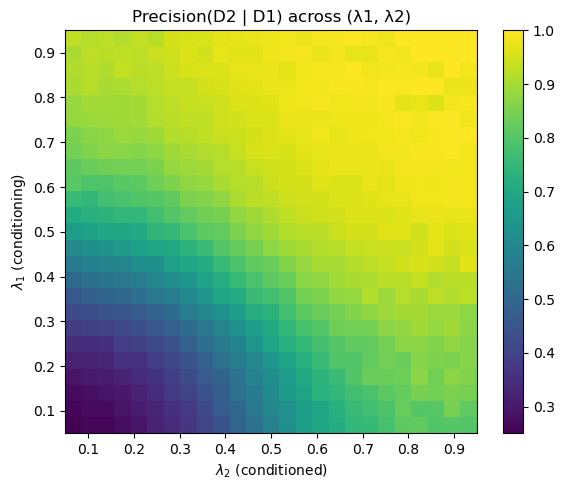

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Local project imports
import sys, os
sys.path.insert(0, "/mnt/data")  # ensure imports work in this environment

from PerformanceGraphsClass import TaxonomyBayesianNetwork, _make_demo_taxonomy
from TaxonomyNodeClass import TaxonomyNode

# ---------- Generic precision/recall models ----------
def logistic(x):
    return 1/(1+np.exp(-x))

def recall_lambda(lam, sens=0.7, scale=8.0):
    # Higher λ => stricter => lower recall
    return logistic(scale*(sens - lam))

def precision_lambda(lam, spec=0.7, scale=8.0):
    # Higher λ => stricter => higher precision
    return logistic(scale*(lam - (1-spec)))

def pr_pair(lam, sens=0.7, spec=0.7, scale=8.0):
    return precision_lambda(lam, spec, scale), recall_lambda(lam, sens, scale)

# ---------- Conditioned detections model ----------
# D2 conditioned on D1: D2 can only fire if D1 fired.
# We parameterize "true positives" as underlying probability mass and form empirical precision/recall from Monte Carlo.

rng = np.random.default_rng(7)

def simulate_conditioned(N, lam1, lam2, sens1=0.7, spec1=0.7, sens2=0.6, spec2=0.65, scale=8.0, negative_parent=False):
    # Ground-truth positives (class P) appear with fixed prevalence
    prevalence = 0.2
    C = rng.random(N) < prevalence

    # D1 base behavior (unconditioned) as a function of λ1
    P1, R1 = pr_pair(lam1, sens1, spec1, scale)

    # Simulate D1
    D1 = np.zeros(N, dtype=bool)
    # True positives for D1
    D1[C] = rng.random(C.sum()) < R1
    # False positives for D1
    idxN = ~C
    D1[idxN] |= rng.random(idxN.sum()) < (1 - P1)  # 1-precision approximates FP propensity

    # D2 base behavior ignoring conditioning
    P2, R2 = pr_pair(lam2, sens2, spec2, scale)

    # For conditioning:
    if not negative_parent:
        # D2 only fires among items where D1 fired
        mask = D1
    else:
        # D2 only fires if D1 did NOT fire
        mask = ~D1

    D2 = np.zeros(N, dtype=bool)
    # Among masked positives, D2 recall applies
    masked_pos = mask & C
    D2[masked_pos] = rng.random(masked_pos.sum()) < R2
    # Among masked negatives, FP rate for D2 approximated from precision
    masked_neg = mask & (~C)
    D2[masked_neg] |= rng.random(masked_neg.sum()) < (1 - P2)

    # Compute empirical precision/recall for D1 and D2
    def pr_stats(D, C):
        TP = np.logical_and(D, C).sum()
        FP = np.logical_and(D, ~C).sum()
        FN = np.logical_and(~D, C).sum()
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        return precision, recall

    p1, r1 = pr_stats(D1, C)
    p2, r2 = pr_stats(D2, C)
    return (p1, r1), (p2, r2)

# Grid of (lam1, lam2)
grid = np.linspace(0.05, 0.95, 25)
Psurf = np.zeros((grid.size, grid.size))

for i, l1 in enumerate(grid):
    for j, l2 in enumerate(grid):
        (_, _), (p2, r2) = simulate_conditioned(
            N=20000, lam1=l1, lam2=l2, sens1=0.72, spec1=0.75, sens2=0.65, spec2=0.7, scale=8.0
        )
        Psurf[i, j] = p2  # precision of the conditioned detection D2|D1

plt.figure(figsize=(6,5))
plt.imshow(Psurf, origin="lower", extent=[grid.min(), grid.max(), grid.min(), grid.max()], aspect="auto")
plt.xlabel(r"$\lambda_2$ (conditioned)")
plt.ylabel(r"$\lambda_1$ (conditioning)")
plt.title("Precision(D2 | D1) across (λ1, λ2)")
plt.colorbar()
plt.tight_layout()
plt.savefig("theorem1_precision_surface.png", dpi=150, bbox_inches="tight")
plt.show()


In [1]:

# --- Robust dynamic import of local modules (Python 3.10 friendly) ---
import importlib.util, sys, os, traceback

def import_from_file(module_name: str, candidates):
    """
    Try to import a module from a list of candidate file paths.
    Returns the imported module or raises with a helpful error.
    """
    last_err = None
    for path in candidates:
        if not os.path.isfile(path):
            continue
        try:
            spec = importlib.util.spec_from_file_location(module_name, path)
            module = importlib.util.module_from_spec(spec)
            # Insert into sys.modules BEFORE exec to satisfy dataclass forward refs on 3.10
            sys.modules[module_name] = module
            spec.loader.exec_module(module)  # type: ignore[attr-defined]
            return module
        except Exception as e:
            last_err = e
            # Clean up and continue trying other paths
            sys.modules.pop(module_name, None)
    # If we get here, show a helpful message
    msg = f"Failed to import {module_name}. Tried paths:\n  " + "\n  ".join(candidates)
    if last_err:
        msg += f"\nLast error:\n{''.join(traceback.format_exception_only(type(last_err), last_err)).strip()}"
    raise ImportError(msg)

# Candidate paths relative to this notebook working dir and /mnt/data (common in hosted settings)
CWD = os.getcwd()
CANDIDATES_TAX = [
    os.path.join(CWD, "TaxonomyNodeClass.py"),
    "/mnt/data/TaxonomyNodeClass.py",
    os.path.join(CWD, "..", "TaxonomyNodeClass.py"),
]
CANDIDATES_PG = [
    os.path.join(CWD, "PerformanceGraphsClass.py"),
    "/mnt/data/PerformanceGraphsClass.py",
    os.path.join(CWD, "..", "PerformanceGraphsClass.py"),
]

TaxonomyNodeClass = import_from_file("TaxonomyNodeClass", CANDIDATES_TAX)
PerformanceGraphsClass = import_from_file("PerformanceGraphsClass", CANDIDATES_PG)

TaxonomyNode = TaxonomyNodeClass.TaxonomyNode
TaxonomyBayesianNetwork = PerformanceGraphsClass.TaxonomyBayesianNetwork

print("✅ Imported modules:",
      TaxonomyNodeClass.__file__, "|", PerformanceGraphsClass.__file__)


✅ Imported modules: /Users/ryanwarnick/Documents/Performance_Graphs_Paper/Performance_Graphs/TaxonomyNodeClass.py | /Users/ryanwarnick/Documents/Performance_Graphs_Paper/Performance_Graphs/PerformanceGraphsClass.py


In [2]:

# --- Build taxonomy identical to paper's structure ---
def build_taxonomy():
    root = TaxonomyNode("ROOT")
    # IMPORTANT: TaxonomyNode doesn't auto-append children; do it explicitly.
    A = TaxonomyNode("A", parent=root); root.children.append(A)
    B = TaxonomyNode("B", parent=root); root.children.append(B)
    H = TaxonomyNode("H", parent=root); root.children.append(H)
    I = TaxonomyNode("I", parent=root); root.children.append(I)

    C = TaxonomyNode("C", parent=A); A.children.append(C)
    F = TaxonomyNode("F", parent=A); A.children.append(F)
    D = TaxonomyNode("D", parent=B); B.children.append(D)

    E = TaxonomyNode("E", parent=C); C.children.append(E)
    G = TaxonomyNode("G", parent=C); C.children.append(G)

    J = TaxonomyNode("J", parent=I); I.children.append(J)
    return root

root = build_taxonomy()
net = TaxonomyBayesianNetwork(taxonomy_root=root)

# Helper: map short names to canonical path names used by network
def pname(short):
    mapping = {
        "ROOT":"ROOT",
        "A":"ROOT/A","B":"ROOT/B","H":"ROOT/H","I":"ROOT/I",
        "C":"ROOT/A/C","F":"ROOT/A/F",
        "D":"ROOT/B/D",
        "E":"ROOT/A/C/E","G":"ROOT/A/C/G",
        "J":"ROOT/I/J"
    }
    return mapping[short]

# Define signed DAG edges (+ requires parent fired; - requires parent NOT fired)
edges = [
    (pname("A"), pname("C"), "+"),
    (pname("C"), pname("E"), "+"),
    (pname("C"), pname("G"), "+"),
    (pname("B"), pname("D"), "+"),
    (pname("D"), pname("E"), "-"),  # a negative dependency example
]
net.set_dag_edges(edges)

# Initialize thresholds to a sane default in [0,1]
for name in net.node_lookup.keys():
    net.thresholds[name] = 0.5

sorted(net.node_lookup.keys())


['ROOT',
 'ROOT/A',
 'ROOT/A/C',
 'ROOT/A/C/E',
 'ROOT/A/C/G',
 'ROOT/A/F',
 'ROOT/B',
 'ROOT/B/D',
 'ROOT/H',
 'ROOT/I',
 'ROOT/I/J']

In [3]:

import numpy as np, pandas as pd

def evaluate_table(network, use_dag=True, N=30000, seed=1337):
    perf = network._evaluate_performance(use_dag=use_dag, N=N)
    df = pd.DataFrame(perf).T.loc[sorted(perf.keys())]
    return df

baseline = evaluate_table(net, use_dag=True, N=30000, seed=1337)
baseline


,precision,recall
ROOT,0.428945,0.694801
ROOT/A,0.427881,0.695080
ROOT/A/C,0.422293,0.277792
ROOT/A/C/E,0.451168,0.100387
ROOT/A/C/G,0.434825,0.117914
ROOT/A/F,0.422437,0.686383
ROOT/B,0.424879,0.690712
ROOT/B/D,0.439010,0.296351
ROOT/H,0.427184,0.693296
ROOT/I,0.425335,0.688418


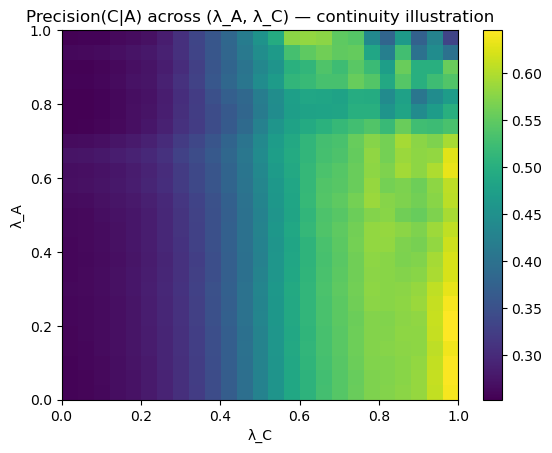

In [4]:

# --- Theorem 1: continuity of Precision(C|A) in (λ_A, λ_C) ---
import numpy as np
import matplotlib.pyplot as plt

lamA = np.linspace(0.0, 1.0, 25)
lamC = np.linspace(0.0, 1.0, 25)
Z = np.zeros((len(lamA), len(lamC)))

for i, la in enumerate(lamA):
    for j, lc in enumerate(lamC):
        net.thresholds.update({pname("A"): float(la), pname("C"): float(lc)})
        perf = net._evaluate_performance(use_dag=True, N=20000)
        Z[i, j] = perf[pname("C")]["precision"]

plt.figure()
plt.imshow(Z, origin="lower",
           extent=[lamC.min(), lamC.max(), lamA.min(), lamA.max()], aspect="auto")
plt.xlabel("λ_C")
plt.ylabel("λ_A")
plt.title("Precision(C|A) across (λ_A, λ_C) — continuity illustration")
plt.colorbar()
plt.show()


In [8]:

# --- Theorem 4: Coordinate-descent equilibrium on (Precision+Recall)^2 ---
rng = np.random.default_rng(2025)
for name in net.node_lookup.keys():
    net.thresholds[name] = float(rng.random())

def evaluate_table(network, use_dag=True, N=40000, seed=2025):
    perf = network._evaluate_performance(use_dag=use_dag, N=N)
    import pandas as pd
    return pd.DataFrame(perf).T.loc[sorted(perf.keys())]

before = evaluate_table(net, use_dag=True, N=40000)
eq_thresholds = net.equilibrium_search(max_iters=30, steps=50, tol=1e-3,
                                       verbose=True, use_dag=True, N=40000)
after = evaluate_table(net, use_dag=True, N=40000)

import pandas as pd
summary = pd.DataFrame({
    "λ_eq": pd.Series(eq_thresholds),
    "precision_before": before["precision"],
    "recall_before": before["recall"],
    "precision_after": after["precision"],
    "recall_after": after["recall"],
}).loc[sorted(net.node_lookup.keys())]

summary


[iter 0] max Δλ = 0.9758
[iter 1] max Δλ = 0.96
[iter 2] max Δλ = 0


,λ_eq,precision_before,recall_before,precision_after,recall_after
ROOT,0.02,0.633634,0.041957,0.259033,0.992146
ROOT/A,0.00,0.346988,0.852563,0.256994,0.991339
ROOT/A/C,0.00,0.598559,0.090612,0.258767,0.963418
ROOT/A/C/E,0.96,0.530120,0.004422,0.666667,0.003618
ROOT/A/C/G,0.00,0.689655,0.002009,0.255565,0.934204
ROOT/A/F,0.00,0.260578,0.985776,0.255716,0.992587
ROOT/B,0.00,0.316874,0.912053,0.258437,0.992770
ROOT/B/D,0.00,0.604494,0.053131,0.258301,0.958819
ROOT/H,0.02,0.547825,0.349508,0.261009,0.989961
ROOT/I,0.00,0.299876,0.922691,0.255473,0.991076
